In [68]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
ai_client.create(
    [
        ai_client.make_msg(
            "You are image descripto. Respond with json of this format: {'description': what you see, 'style': stylistics of the image, 'prompt': short description of charachter, style and cloth}",
            role=ROLE_SYSTEM,
        ),
        ai_client.make_msg(
            text="What's in this image?",
            img="https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500",
        ),
    ],
    format=JSON_MODE,
)

'{\n  "description": "A cream-colored kitten with blue eyes is resting its paws on the edge of a leopard print blanket. The background is dark, putting emphasis on the kitten\'s light fur.",\n  "style": "Cute and adorable pet photography, close-up shot.",\n  "prompt": "A close-up of a cream-colored kitten with blue eyes, resting on a leopard print blanket, dark background."\n}'

In [70]:
coin = "ETH"
cutoff = subtract_time(get_current_datetime(), days=0)
day_history, week_history, month_history = map_async(lambda: get_day_history(coin, cutoff), lambda: get_week_history(coin, cutoff), lambda: get_month_history(coin, cutoff))

In [71]:
day_history[0]

{'t': 1716053400000.0,
 'o': 3115.25,
 'h': 3116.4,
 'l': 3110.61,
 'c': 3111.0,
 'v': 978.3239}

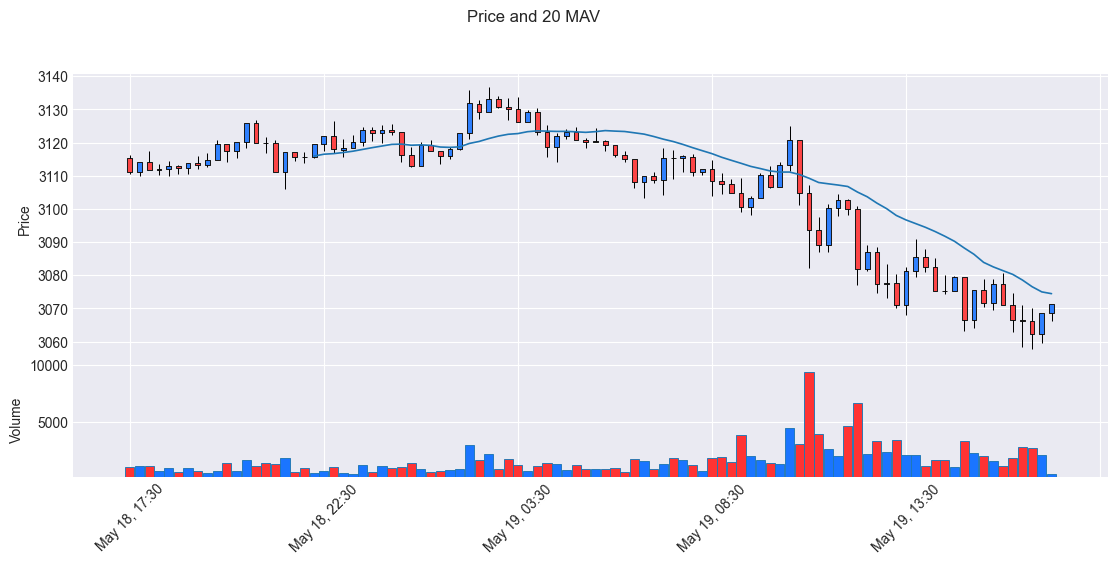

In [72]:
make_candlebars(day_history)

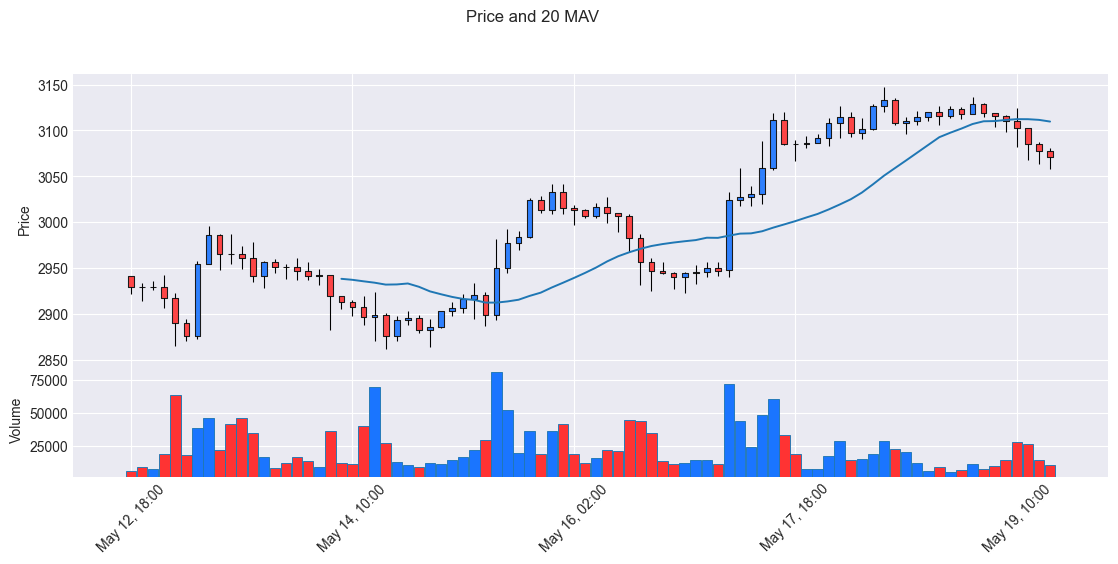

In [75]:
make_candlebars(week_history)

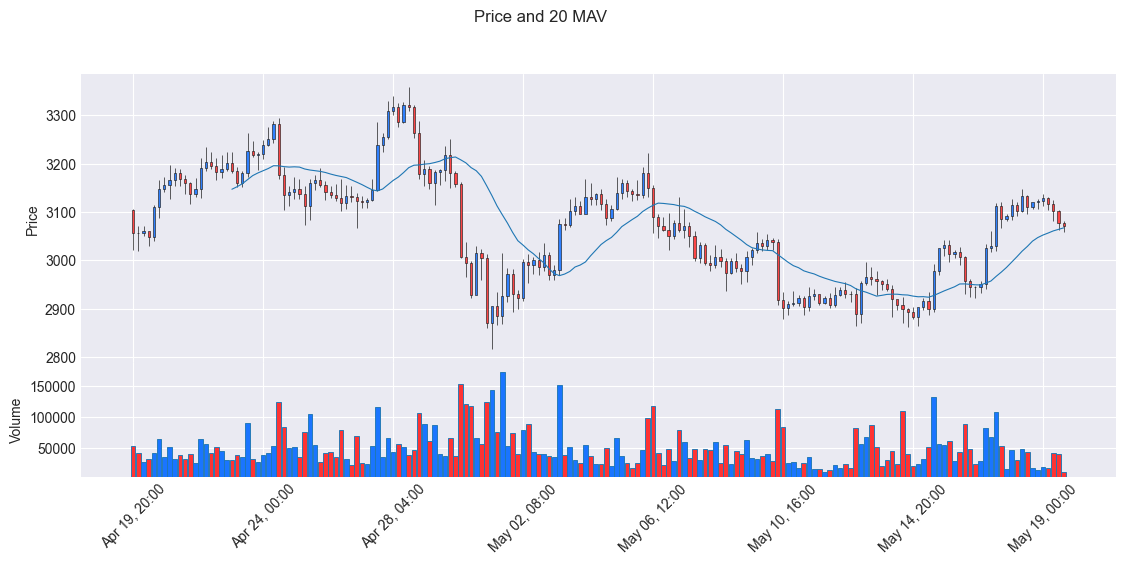

In [76]:
make_candlebars(month_history)

In [77]:
res = ai_client.create(
    [
        ai_client.make_msg(
            "You are professional trader",
            role=ROLE_SYSTEM,
        ),
        ai_client.make_msg(
            text="What is shown on this image, what are the trends and prices? What do you expect prices to be in a week?",
            img=make_candlebars(week_history, useBuf=True),
        ),
    ],
    #format=JSON_MODE,
)

res

'This image shows a candlestick chart with trading volumes and a 20-period moving average (blue line) over a period of days (May 12 to May 19). Here is the analysis:\n\n### Price Trend:\n1. **Downtrend to Mid-May**: The price was in a downtrend until about mid-May, with notable declines below the 2900 price level.\n2. **Reversal and Uptrend**: Around May 15, the price started to reverse and trend upward, surpassing the 20-period moving average.\n3. **Peak and Slight Decline**: After reaching around 3150, a peak in price occurred followed by a slight downtrend around May 18-19.\n\n### Moving Average:\n- The price crossed above the 20-period moving average around May 15, indicating a bullish trend.\n- The moving average subsequently started to trend upwards, reflecting the upward momentum.\n- Towards the end, the price starts to move downward, crossing the moving average from above signaling potential weakening.\n\n### Volume:\n- Higher trading volume is observed during significant price

In [83]:
napi = NewsApi()
news = napi.get_news(coin, start_date="2024-05-01")
filtering_agent = NewsFilteringAgent()
filtered_news = filtering_agent.filter_news(news=news, coin=coin)

json.loads(filtered_news)

{'description': "The past week has seen a mix of significant developments in the cryptocurrency market, specifically concerning Ethereum (ETH). Regulations and security issues have taken the spotlight. Prominently, two MIT students were charged with exploiting an ETH blockchain bug to steal $25 million, raising concerns about the security of decentralized finance (DeFi). Additionally, the Parity hacker from 2017 resurfaced, moving $9 million in Ethereum, while another hacker laundered $3.4 million through Tornado Cash. These incidents highlight vulnerabilities within the ETH ecosystem. Meanwhile, debates about the classification of Ethereum as a security by the U.S. SEC escalated, with Ethereum co-founder Joseph Lubin actively challenging the regulatory stance, fearing it could hamper user adoption. Market sentiment was further influenced by a significant sell-off from one of the oldest Ethereum whales, possibly indicating investor uncertainty. Yet, some analysts predict a positive out

[{'role': 'system', 'content': "You are professional trader with an extensive understanding of cryptocurrency markets. \n                \n                Respond with JSON of described format\n                Guidelines:\n                - Do not buy on everything you have, distribute spendings!\n                - Feel free to sell all if selling improves total net_worth of acccount\n                - Consider historical market data and recent news.\n                - Use only money from your 'balance'\n                - Never close deals resulting in negative balance\n                - Never sell if you will loose money after it\n                \n                Your ultimate goal is to make 3k$\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last day. Current price: 3071.27'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price 
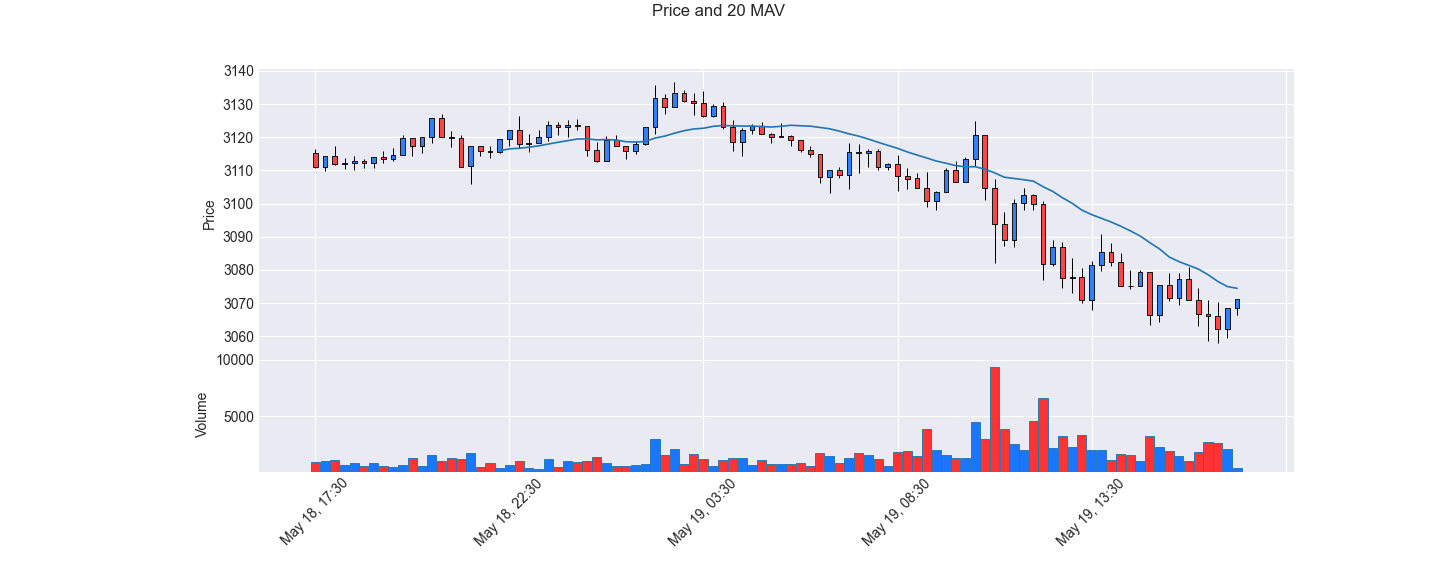
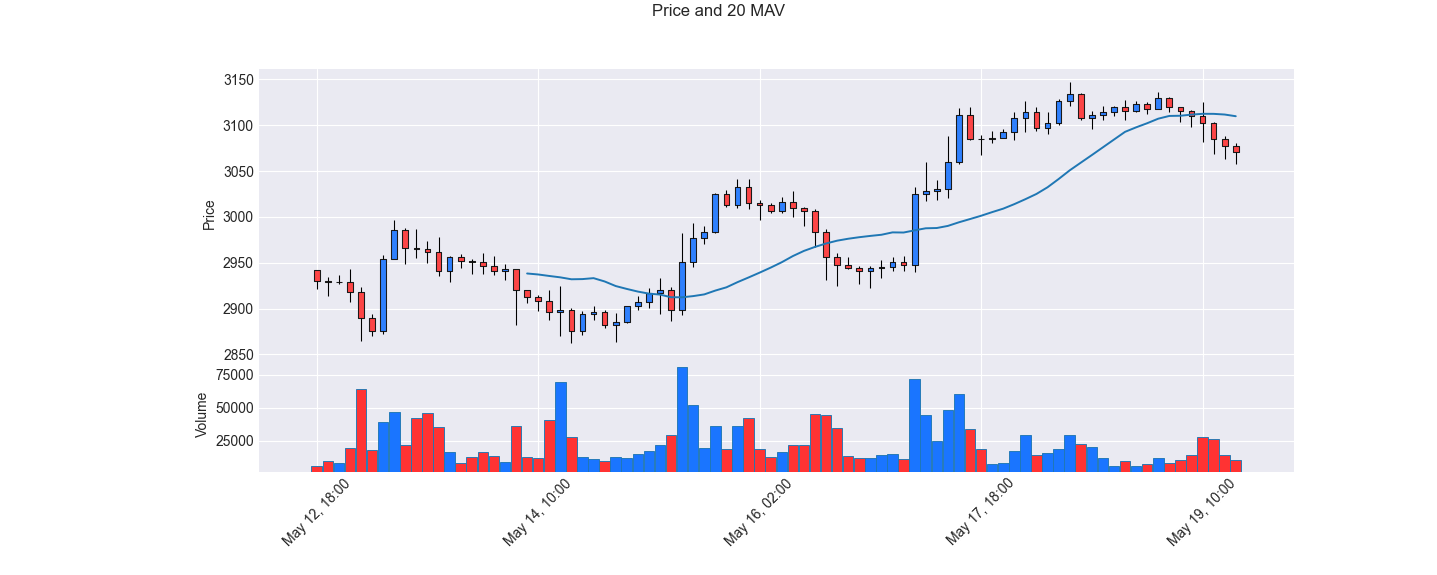
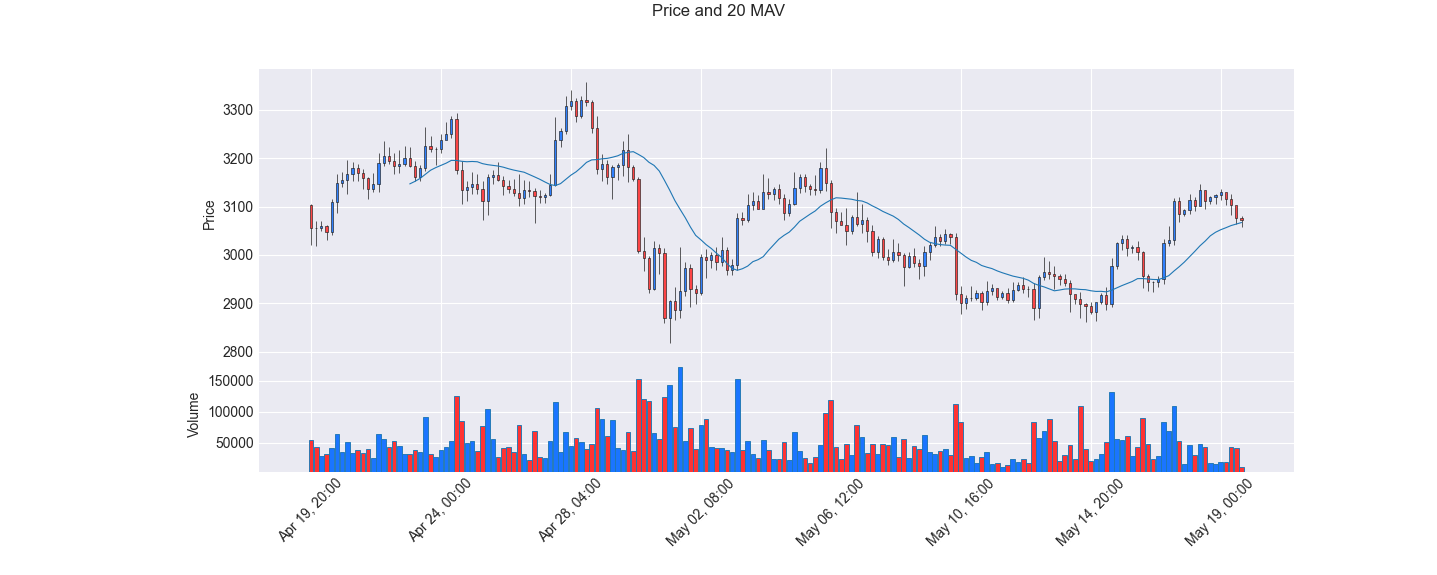

('{\n    "trend_analysis": "Based on the price history, we have seen the coin\'s price decline from above 3100 down to the current price of 3071.27 over the last day. Over the past week, the price peaked at around 3150 but trended downwards near the end. The monthly view shows significant volatility, with highs reaching around 3300. The recent news indicates mixed sentiment due to security breaches, regulatory concerns, and some optimistic future projections. This suggests a cautious market with both bullish and bearish influences at play.",\n    "technical_analysis": "The 20 Moving Average (MA) indicates a downward trend over the last day and week, suggesting bearish momentum. The volume spikes, especially during significant price drops, indicate strong selling pressure. The month-long view shows a pattern of volatility with potential for recovery, but in the short term, market sentiment appears to be cautious.",\n    "price": "3071.27",\n    "profits_on_sell": "Selling 1 ETH at the c
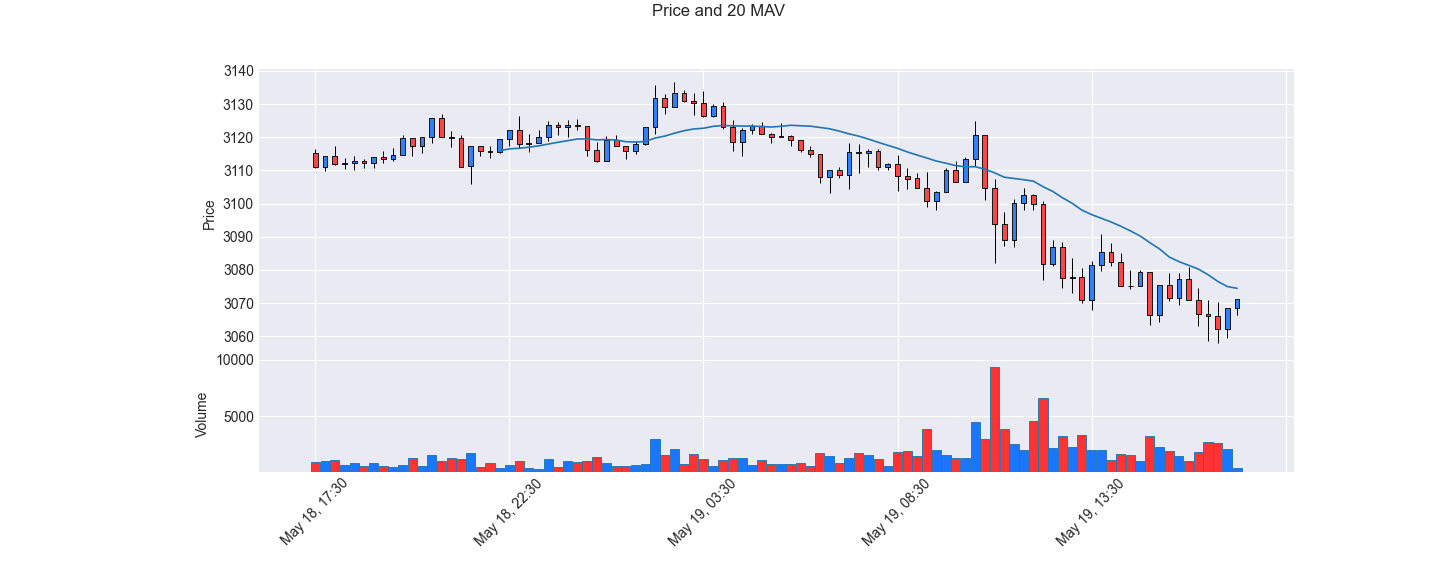
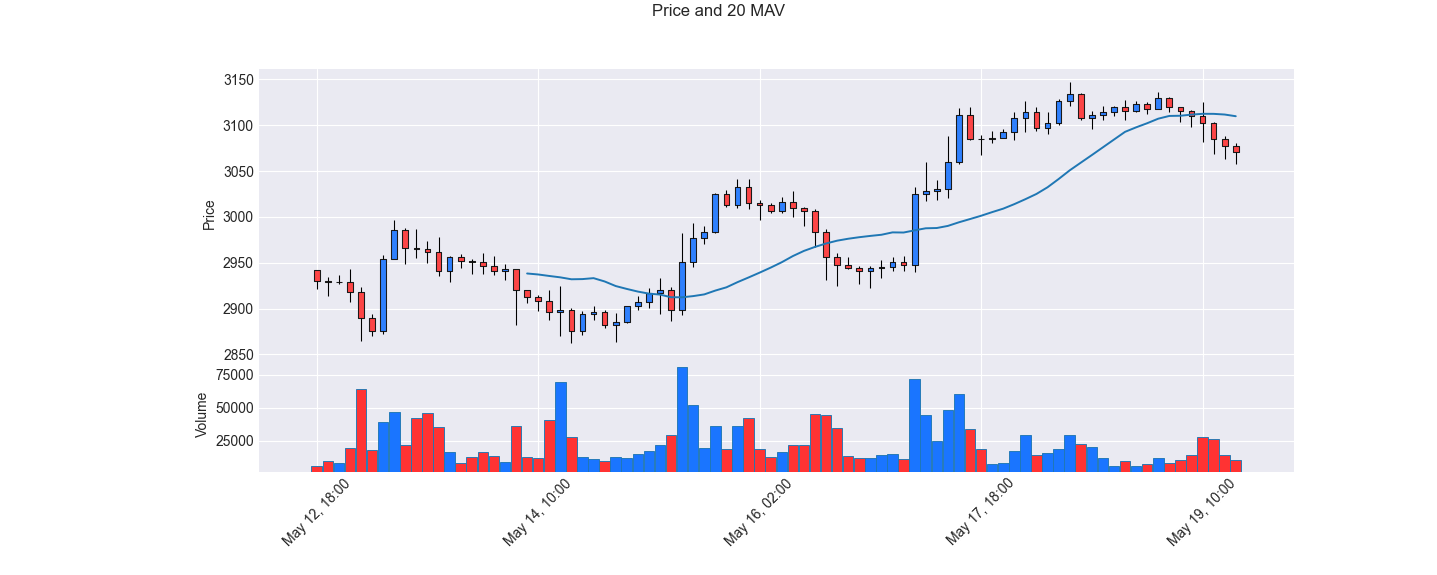
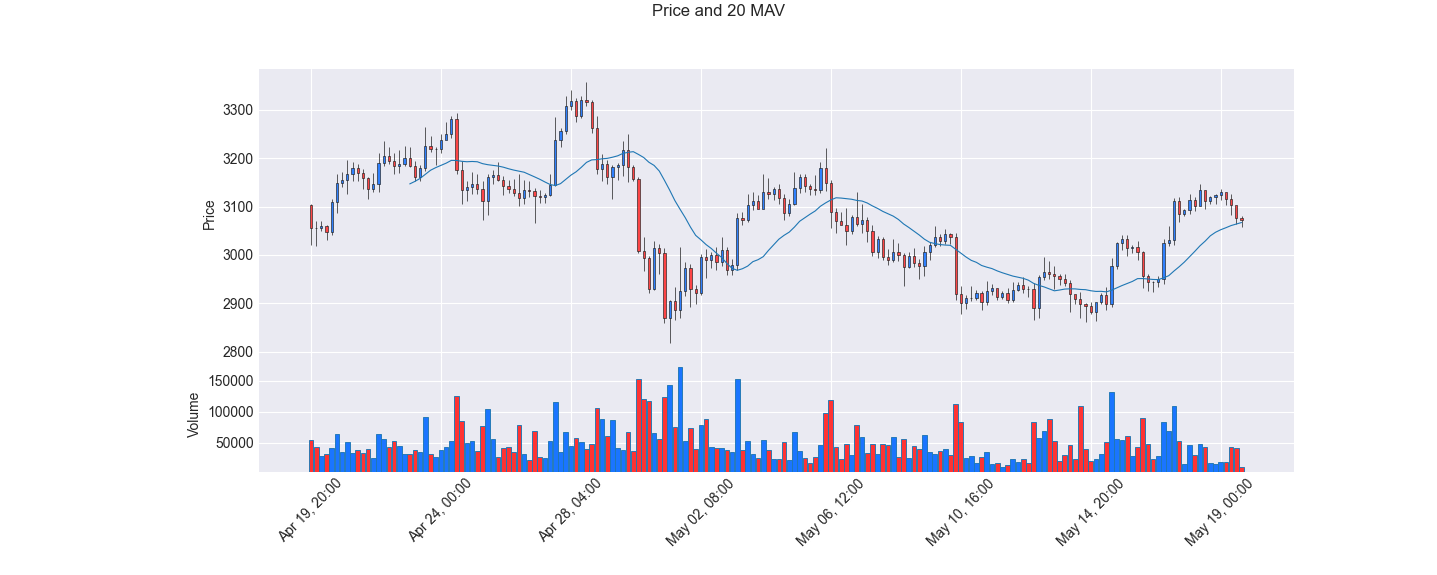

In [85]:
trading_agent = TradingAgent()
predict = trading_agent.decide(
    coin=coin,
    news=filtered_news,
    day_data=day_history,
    week_data=week_history,
    month_data=month_history,
    operations_history=[
        {"action": "buy", "amount": 1, "price": 6.286, "date": "20.04 08:41"}
    ],
    current_balance={coin: 1, "USDT": 56.14},
    verbose=True
)

predict

In [86]:
from src.signal_providers.bybit_bid_ask import BybitBidAskProvider

bid_ask_provider = BybitBidAskProvider()

In [87]:
coin = "ETH"
day_history = get_day_history(coin)
bid_ask = bid_ask_provider.get_data(coin)

In [88]:
heights = [[x["price"], x["amount"]] for x in bid_ask["bid"]]
ask_heights = [[x["price"], -x["amount"]] for x in bid_ask["ask"]]
heights.extend(ask_heights)

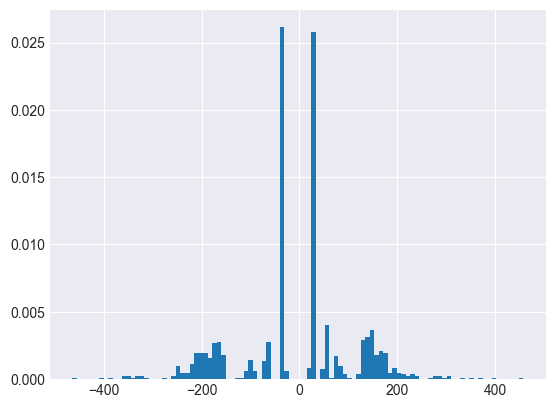

In [89]:
plt.hist([x[1] for x in heights if abs(x[1]) < 500], density=True, bins=100)
plt.show()

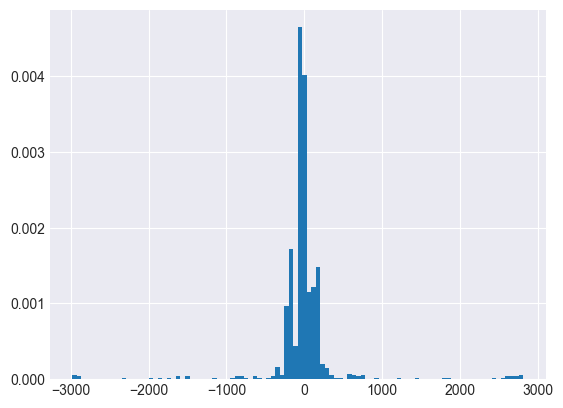

In [90]:
plt.hist([x[1] for x in heights if abs(x[1]) < 3000], density=True, bins=100)
plt.show()

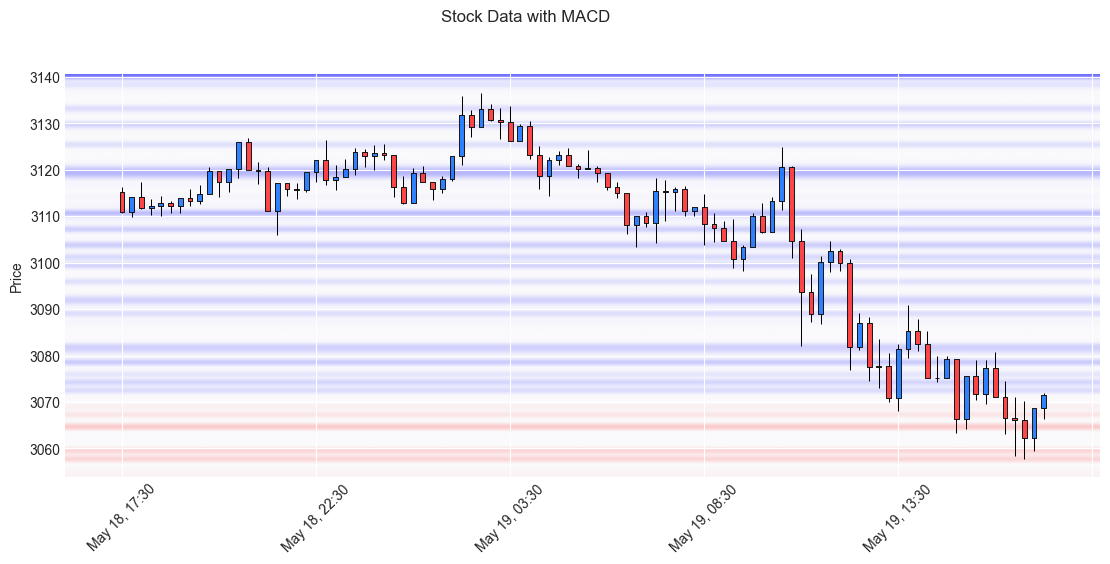

In [91]:
plot_candles_overlay(day_history, heights=heights, display_range=(-400, 400), figsize=(20, 8))